# Trabajo Práctico 1: Propiedades en Venta - Support Vector Machine

## Grupo 11 - "Los Outliers"
- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

# Setup Inicial

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
sns.set_theme()
sns.set_palette("colorblind")

Trabajamos con el dataset ya modificado luego de las operaciones de preprocesamiento que se hicieron para el checkpoint 1.

In [49]:
df = pd.read_csv("propiedades.csv", index_col=0)

# Transformación de Datos

Las Support Vector Machines no pueden trabajar con datos categóricos, sin embargo queremos tenerlos en cuenta durante al análisis. Para esto debemos transformar las categorías en datos numéricos utilizando OneHot Encoding. Dropeamos la primera columna ya que no es necesario agregar esta columna adicional si consideramos a un registro con todos 0 como perteneciente a la categoría de la columna eliminada.

In [50]:
df_dummies = pd.get_dummies(df, columns=["property_type", "neighbourhood"], drop_first=True)

Las columnas con las que nos queda nuestro dataset son todas las que ya teníamos con anterioridad más una categoría por cada barrio, con el nombre del barrio antecedido por `neighbourhood_` y una categoría para cada tipo de propiedad, antecedido por `property_type_`. Nótese que se eliminaron las columnas categóricas originales correspondientes.

In [51]:
df_dummies.columns

Index(['id', 'start_date', 'end_date', 'latitud', 'longitud', 'property_rooms',
       'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price', 'property_title',
       'precio_m2', 'tipo_precio', 'property_type_Departamento',
       'property_type_PH', 'neighbourhood_Agronomía', 'neighbourhood_Almagro',
       'neighbourhood_Balvanera', 'neighbourhood_Barracas',
       'neighbourhood_Barrio Norte', 'neighbourhood_Belgrano',
       'neighbourhood_Boca', 'neighbourhood_Boedo', 'neighbourhood_Caballito',
       'neighbourhood_Catalinas', 'neighbourhood_Centro / Microcentro',
       'neighbourhood_Chacarita', 'neighbourhood_Coghlan',
       'neighbourhood_Colegiales', 'neighbourhood_Congreso',
       'neighbourhood_Constitución', 'neighbourhood_Flores',
       'neighbourhood_Floresta', 'neighbourhood_Las Cañitas',
       'neighbourhood_Liniers', 'neighbourhood_Mataderos',
       'neighbourhood_Monserrat', 'neighbourhood_Monte Castro',
       'nei

In [52]:
df = df_dummies

In [53]:
from sklearn.model_selection import train_test_split

onehot_cols = [col for col in df.columns if col.startswith(("property_type_","neighbourhood_"))]
num_cols = ["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered"]

X = df[onehot_cols + num_cols]
y = df["tipo_precio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=137)

También se hará uso de la técnica de scaling, primero en el set de entrenamiento para no tener en cuenta los datos que están en el set de test al momento de determinar los rangos de escalado. Hacemos esto porque algoritmos como las Support Vector Machines, que utilizan medidas de distancia para hacer comparaciones entre samples, pueden ser afectados por las diferentes unidades de medida entre las columnas al momento de hacer estas comparaciones de distancia, por lo que trasladamos todas estas distancias a rangos acotados similares para hacer una comparación más directa.

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
    ("scaling", StandardScaler(), num_cols)
], remainder="passthrough")

X_train_trans = ct.fit_transform(X_train)

# Entrenamiento

Las Support Vector Machines tienen un hiperparámetro conocido como "kernel", que va a ser la función que hace las comparaciones entre los resgistros como si se estuviera aumentando la dimensionalidad del problema, pero sin realmente hacer esta transformación para hacer la operación de manera más óptima (técnica conocida como Kernel Trick).

En esta ocasión probamos con tres tipos de kernel diferentes:
- Lineal
- Polinómico
- RBF (infinitas dimensiones, idea similar a KNN)

Para los tres tipos de kernel se prueban los mismos valores del hiperparámetro "C", una constante que es tenida en cuenta al momento de hacer las comparaciones de mayor dimensionalidad. Este hiperparámetro también sirve como parámetro de regularización, es decir, ayuda a evitar el overfitting. Esto es especialmente útil para los polinomios de mayor grado.

Específicamente para el kernel polinómico se probaron polinomios de grados 2, 3 y 4.

En el caso del kernel RBF, se utilizaron los valores sugeridos por sklearn para el hiperparámetro "Gamma" (https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#train-classifiers). Este parámetro determina el radio de influencia de las comparaciones con los support vectors.

Utilizamos `HalvingGridSearch` para optimizar el proceso de Grid Search y también `StratifiedShuffleSplit` para obtener splits de Cross-Validation con cantedidas representativas de todos los grupos.

In [55]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

Cs = [1, 10, 100, 1000]

params = [
    {"C": Cs, "kernel": ["linear"]},
    {"C": Cs, "degree": [2, 3, 4], "kernel": ["poly"]},
    {"C": Cs, "gamma": np.logspace(-9, 3, 13), "kernel": ["rbf"]},
]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
clf = HalvingGridSearchCV(estimator=SVC(),
                          param_grid=params,
                          cv=cv,
                          scoring="accuracy",
                          verbose=2)

Para entrenar al modelo utilizamos el método fit con el set de entrenamiento ya transformado:
```python
clf.fit(X_train_trans, y_train)
```
Sin embargo, luego de haber ejecutado este método con anterioridad, ya contamos con el modelo más óptimo encontrado, que ha sido exportado en un archivo de joblib, lo que nos permite simplemente cargar el archivo y no tener que volver a entrenar todos los modelos con todos los parámetros que probamos.

Tras el entreno, el modelo con mejor rendimiento resultó ser el que utiliza el kernel RBF, con constante de regularización 1 y parámetro Gamma 1.0.

In [56]:
from joblib import load, dump

svm = load("svm.joblib")
svm.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Evaluación

Ahora utilizamos el modelo con dataset de test para evaluar el rendimiento del mismo ante datos que nunca ha visto. Para esto tenemos que aplicarle las mismas transformaciones al conjunto de test que utilizamos con el conjunto de entrenamiento. En este caso solo nos hace falta aplicar el scaling, ya que el One-Hot Enconding se lo aplicamos a todo el dataset desde el inicio.

In [57]:
X_test_trans = ct.fit_transform(X_test)

In [58]:
y_pred = svm.predict(X_test_trans)

Para interpretar el resultado visualmente, utilizamos una matriz de confusión, que nos permite ver la cantidad de propiedades correcta e incorrectamente clasificadas para cada categoría, comparando los resultados esperados (almacenados en la variable `y_test`) con los resultados obtenidos (almacenados en la variable `y_pred`).

Text(46.25, 0.5, 'Predicción')

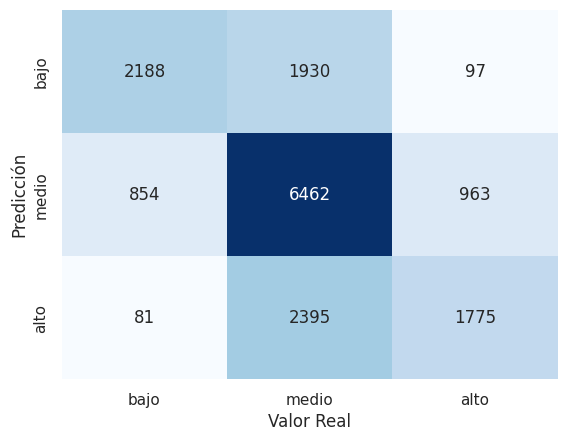

In [59]:
from sklearn.metrics import confusion_matrix

labels = ["bajo", "medio", "alto"]
conf = confusion_matrix(y_test, y_pred, labels=labels)

sns.heatmap(conf, cmap="Blues", annot=True, cbar=False, fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("Valor Real")
plt.ylabel("Predicción")

También podemos analizar las matrices de confusión para cada una de las categorías.

In [60]:
from matplotlib.colors import ListedColormap

def matriz_confusion_clase(matriz, nombre_clase):
  labels = [nombre_clase, "no " + nombre_clase]

  matriz = matriz.T
  matriz[0][0], matriz[1][1] = matriz[1][1], matriz[0][0]

  mask = np.ones_like(matriz, dtype=bool)
  np.fill_diagonal(mask, False)

  cmap_diagonal = ListedColormap(["lightsteelblue"])
  cmap_off_diagonal = ListedColormap(["midnightblue"])

  sns.heatmap(matriz, mask=mask, cmap=cmap_off_diagonal, annot=True, cbar=False, fmt="g", xticklabels=labels, yticklabels=labels)
  sns.heatmap(matriz, mask=~mask, cmap=cmap_diagonal, annot=True, cbar=False, fmt="g", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Valor Real")
  plt.ylabel("Predicción")

In [61]:
from sklearn.metrics import multilabel_confusion_matrix

confs = multilabel_confusion_matrix(y_test, y_pred, labels=labels)
conf_bajo, conf_medio, conf_alto = confs[0], confs[1], confs[2]

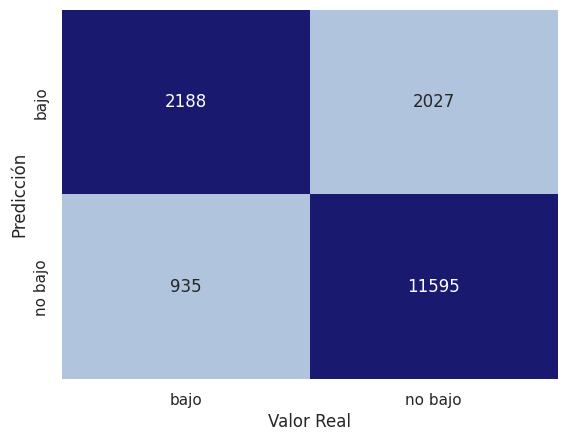

In [62]:
matriz_confusion_clase(conf_bajo, "bajo")

Los resultados para la categoría "bajo" fueron los siguientes:
- TP: 2188
- TN: 11595
- FP: 2027
- FN: 935

El detalle más llamativo es que la cantidad de False Positives es bastante alta, casi igual que la cantidad de True Positives. Es decir, que el modelo tiende a considerar a varias propiedades como propiedades con precio bajo cuando realmente no lo son. Podemos observar la precisión de la clasificación de los precios bajos y notamos que esta tienen un valor bajo:

$$
\text{Precision}=\frac{\text{TP}}{\text{TP + FP}}=\frac{2188}{2188 + 2027}\approx0.5191
$$

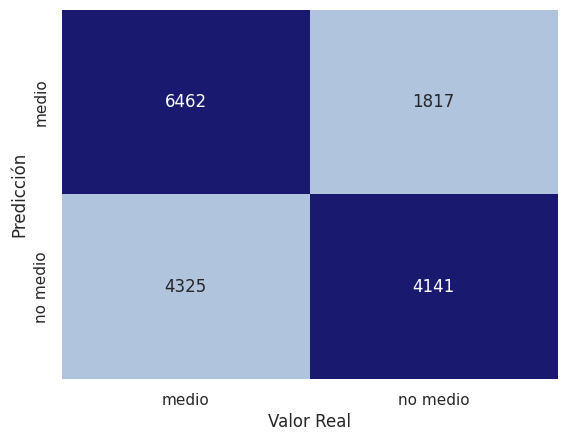

In [63]:
matriz_confusion_clase(conf_medio, "medio")

Para la categoría "medio" la matriz de confusión nos arroja los siguientes valores:
- TP: 4141
- TN: 6464
- FP: 1817
- FN: 4325

En este caso advertimos la similitud entre la cantidad de False Negatives con True Negatives y True Positives. Podemos cuantificar esta relación calculado el recall:

$$
\text{Recall}=\frac{\text{TP}}{\text{TP + FN}}=\frac{6462}{6462 + 4325}\approx0.5991
$$

Es decir que el modelo indica que bastantes propiedades de precio medio no son de precio medio cuando en realidad sin lo son.

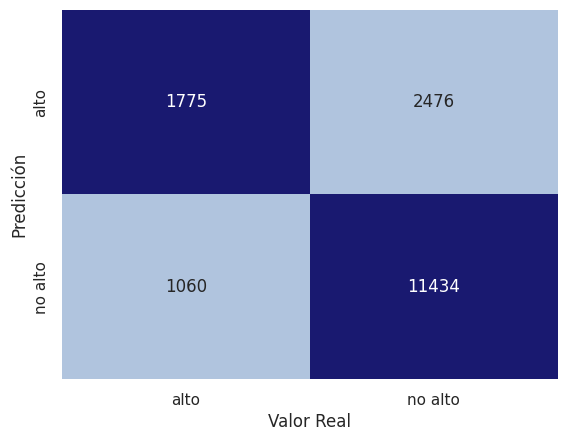

In [64]:
matriz_confusion_clase(conf_alto, "alto")

En este caso notamos a primera vista que la cantidad de True Positives es significativamente mayor a la de las demás categorías.
- TP: 11434
- TN: 1775
- FP: 2476
- FN: 1060

En este último caso notamos que la cantidad de clasificados como propiedades de precio alto cuando en realidad no lo son supera al número de correctamente clasificados como precio no alto. Pudimos haber esperado esta tendencia a clasificar las propiedades como propiedades de precio alto al ver el desempeño individual en las categorías "bajo" y "medio". Podemos cuantificarlo utilizando el False Positives Rate:

$$
\text{FPR}=\frac{\text{FP}}{\text{FP + TN}}=\frac{2476}{2476 + 1775}\approx0.5824
$$

Este número nos confirma esto.

Finalmente, podemos ver algunas métricas como f1-score, precision, recall y accuracy para todos los resultados del modelo, para hacernos una idea de su rendimiento en general.

In [65]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("Recall: {}".format(recall_score(y_test, y_pred, average="weighted")))
print("Precision: {}".format(precision_score(y_test, y_pred, average="weighted")))
print("f1 score: {}".format(f1_score(y_test, y_pred, average='weighted')))

Accuracy: 0.6225739026575097
Recall: 0.6225739026575097
Precision: 0.6314838297418703
f1 score: 0.6124379835539216


Comparamos el rendimiento con el conjunto de test con el rendimiento con el conjunto de entrenamiento:

In [66]:
y_train_pred = svm.predict(X_train_trans)

In [68]:
print("Accuracy: {}".format(accuracy_score(y_train, y_train_pred)))
print("Recall: {}".format(recall_score(y_train, y_train_pred, average="weighted")))
print("Precision: {}".format(precision_score(y_train, y_train_pred, average="weighted")))
print("f1 score: {}".format(f1_score(y_train, y_train_pred, average='weighted')))

Accuracy: 0.6504322379324246
Recall: 0.6504322379324246
Precision: 0.6601781927047664
f1 score: 0.6412068569308452
